In [3]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

In [66]:
'''
This function finds the descents indices in a sequence
'''
def find_descents_in_sequence(sequence):
    descents = []
    for i in range(0, len(sequence)-1):
        if sequence[i] > sequence[i + 1]:
            descents.append(i+1) #change from 0 to 1 indexing for plotting reasons
    return descents, True

# Example sequence
sequence = [4, 6, 3, 8, 7, 7, 2]

# Find and print descents
descents = find_descents_in_sequence(sequence)
print("Positions of descents:", descents)

Positions of descents: ([2, 4, 6], True)


In [5]:
sequences = [np.random.randint(0, 3, size=6) for _ in range(100000)]
all_descents = []
for seq in sequences:
    all_descents.extend(find_descents_in_sequence(seq,_))
print(all_descents)

TypeError: find_descents_in_sequence() takes 1 positional argument but 2 were given

In [6]:
import sympy as sp

def compute_coefficients(b):
    t = sp.symbols('t')
    expansion = sp.series(1 / (1 - (1 - t)**b), t, 0, 21).removeO()
    # Get coefficients for m = -10 to 10
    coeffs = [expansion.coeff(t, n) for n in range(-10, 11)]
    return coeffs

b = 3  
coefficients = compute_coefficients(b)
coeff_dict = {m: coeff for m, coeff in enumerate(coefficients, start=-10)}
size = 6
kernel_matrix = np.zeros((size, size))

for i in range(size):
    for j in range(size):
        m = j - i  
        # Convert the sympy Rational to a float before assigning
        kernel_matrix[i, j] = float(coeff_dict.get(m, 0))

print(kernel_matrix) # this is the Kernel Matric for Random Descent Indices



[[ 0.33333333  0.22222222  0.11111111  0.03703704  0.         -0.01234568]
 [ 0.33333333  0.33333333  0.22222222  0.11111111  0.03703704  0.        ]
 [ 0.          0.33333333  0.33333333  0.22222222  0.11111111  0.03703704]
 [ 0.          0.          0.33333333  0.33333333  0.22222222  0.11111111]
 [ 0.          0.          0.          0.33333333  0.33333333  0.22222222]
 [ 0.          0.          0.          0.          0.33333333  0.33333333]]


In [76]:
def bernoulli_trial(p):
    return np.random.rand() < p

def poulson_dpp_sampling(K):
    n = K.shape[0]
    sample = []
    A = np.array(K, dtype=float)

    for j in range(n):
        if bernoulli_trial(A[j, j]):
            sample.append(j+1)
        else:
            A[j, j] -= 1 
        A[j+1:n, j] /= A[j, j]  
        A[j+1:n, j+1:n] -= np.outer(A[j+1:n, j], A[j, j+1:n])
    return sample, A


In [77]:
print(kernel_matrix[0:3])

[[ 0.33333333  0.22222222  0.11111111  0.03703704  0.         -0.01234568]
 [ 0.33333333  0.33333333  0.22222222  0.11111111  0.03703704  0.        ]
 [ 0.          0.33333333  0.33333333  0.22222222  0.11111111  0.03703704]]


In [54]:
sample, A = poulson_dpp_sampling(kernel_matrix)
print(sample)

[2, 5, 6]


In [8]:
def find_descents_in_sequence_filtered(sequence, s):
    descents = []
    for i in range(1, len(sequence)):
        if sequence[i] < sequence[i - 1]:
            descents.append(i)
    # Filter out descents with indices greater than s
    descents = [d for d in descents if d < s]
    return descents, True

# Example sequence
sequence = [4, 6, 3, 8, 7, 7, 2]
s = 5  # Indices greater than s will be ignored in the descents list

# Find and print descents, ignoring indices greater than s
descents = find_descents_in_sequence_filtered(sequence, s)
descents

([2, 4], True)

In [11]:
def find_descents_and_check_validity(sequence, s):
    """
    Finds descents in the sequence and checks if the sequence is valid (contains nothing <= s).

    Parameters:
    sequence (list of int): The sequence to analyze.
    s (int): Threshold value for filtering the sequence.

    Returns:
    tuple: A tuple containing a list of descents and a boolean indicating sequence validity.
    """
    descents = []
    for i in range(1, len(sequence)):
        if sequence[i] < sequence[i - 1]:
            descents.append(i)
    
    # Check if the sequence is valid
    is_valid = all(item > s for item in descents)
    
    return descents, is_valid

In [12]:
sample, A = poulson_dpp_sampling(kernel_matrix)
print(sample)

[1, 4, 6]


In [29]:
kernel_matrix

array([[ 0.33333333,  0.22222222,  0.11111111,  0.03703704,  0.        ,
        -0.01234568],
       [ 0.33333333,  0.33333333,  0.22222222,  0.11111111,  0.03703704,
         0.        ],
       [ 0.        ,  0.33333333,  0.33333333,  0.22222222,  0.11111111,
         0.03703704],
       [ 0.        ,  0.        ,  0.33333333,  0.33333333,  0.22222222,
         0.11111111],
       [ 0.        ,  0.        ,  0.        ,  0.33333333,  0.33333333,
         0.22222222],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.33333333,
         0.33333333]])

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def distr_of_indices(empirical_function, kernel_matrix):
    n_samples = 1000000
    # Generate sequences
    sequences = [np.random.randint(1, 4, size=7) for _ in range(n_samples)]  
    # Calculate empirical descent frequencies
    empirical_values = []
    ret_emprical = []
    ret_dpp = []
    for seq in sequences:
        descents, is_valid = empirical_function(seq)
        empirical_values.extend(descents)  
        ret_emprical.append(descents)
    sample_counts =[]  
    for i in range(0,n_samples):
        sample, _ = poulson_dpp_sampling(kernel_matrix)
        sample_counts.extend(sample)
        ret_dpp.append(sample)

   
     # Count the frequency of each index
    empirical_freq = Counter(empirical_values)
    sample_freq = Counter(sample_counts)

    # Normalize the frequencies by dividing by the total number of samples
    empirical_normalized = {k: v / len(empirical_values) for k, v in empirical_freq.items()}
    sample_normalized = {k: v / len(sample_counts) for k, v in sample_freq.items()}
    # Prepare the data for plotting
    indices = range(1, 7)
    empirical_data = [empirical_normalized.get(i, 0) for i in indices]
    sample_data = [sample_normalized.get(i, 0) for i in indices]
    
    # Set the positions and width for the bars
    pos = np.arange(len(indices))
    bar_width = 0.35

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(15, 10))
    bars1 = ax.bar(pos - bar_width/2, empirical_data, bar_width, label='Empirical Frequencies', color='blue')
    bars2 = ax.bar(pos + bar_width/2, sample_data, bar_width, label='DPP Sampled Frequencies', color='orange')

    # Adding the text on top of the bars
    def add_values_on_bars(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.6f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_values_on_bars(bars1)
    add_values_on_bars(bars2)

    # Adding labels and title
    ax.set_xticks(pos)
    ax.set_xticklabels([str(i) for i in indices])
    ax.set_xlabel('Position in Sequence')
    ax.set_ylabel('Proportion')
    ax.set_title('Normalized Comparison of Descent Frequencies')
    plt.legend()

    # print("--------------")
    # print(ret_emprical)
    # print(ret_dpp)
    # Show the plot
    plt.tight_layout()
    # plt.show()
    return ret_emprical, ret_dpp, empirical_freq, sample_freq
    



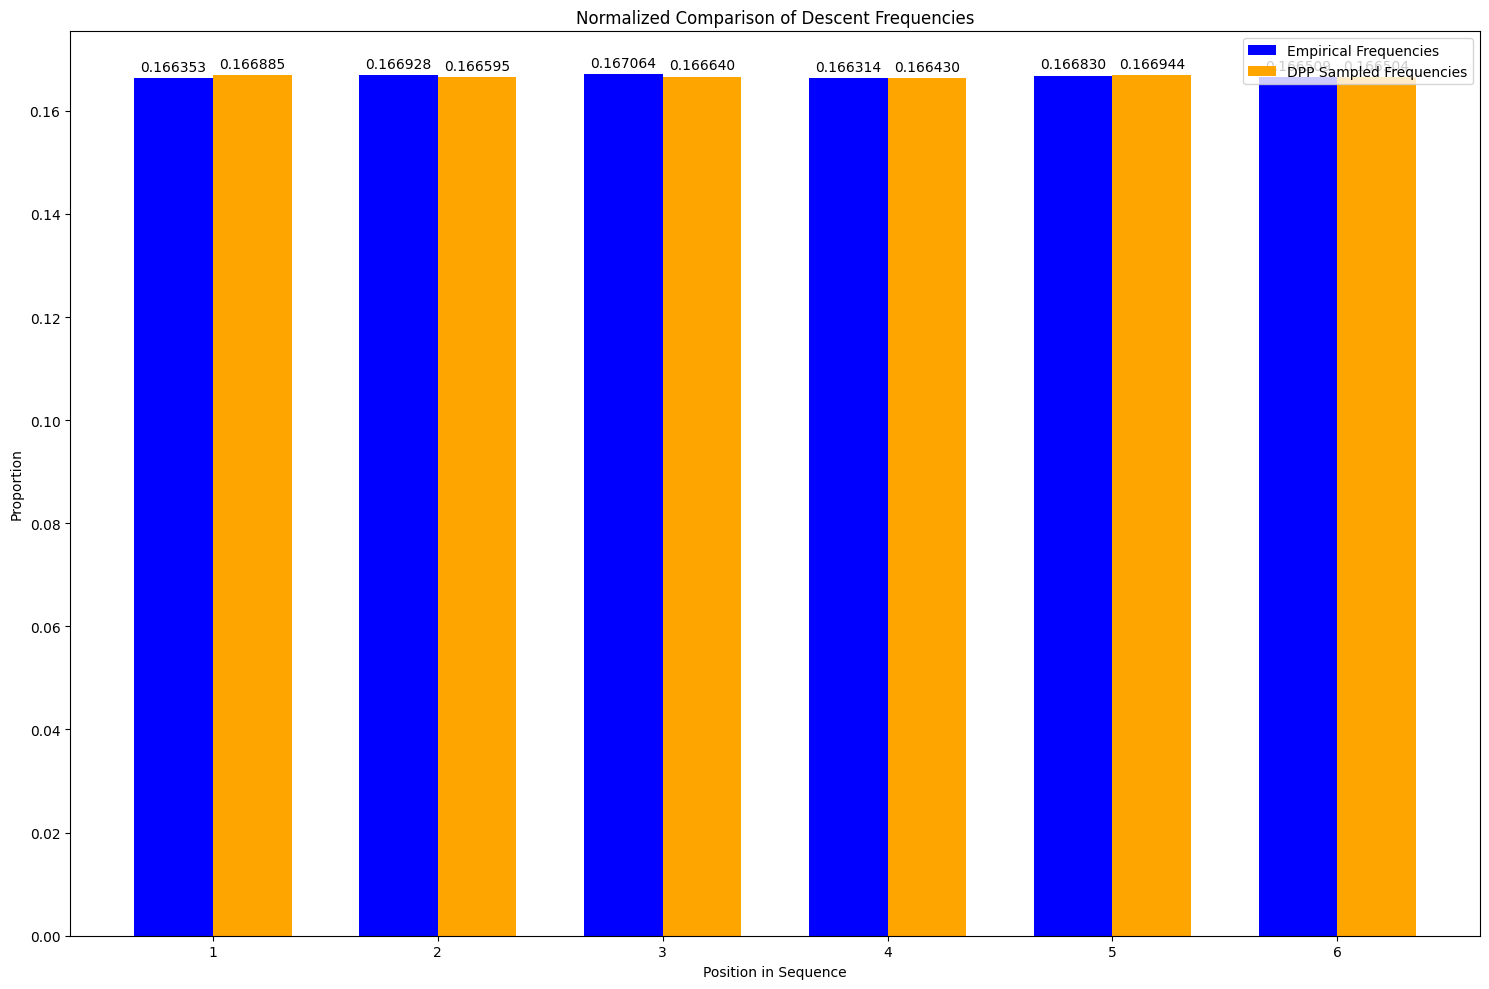

In [84]:
ret_emprical, ret_dpp, empirical_freq, sample_freq = distr_of_indices(find_descents_in_sequence, kernel_matrix)
# print(ret_emprical)
# print(ret_dpp)
# print(empirical_freq)
# print(sample_freq)

In [57]:
print(empirical_freq)
print(sample_freq)

Counter({3: 33609, 6: 33422, 1: 33350, 5: 33291, 2: 33115, 4: 33010})
Counter({5: 33480, 4: 33435, 2: 33304, 6: 33253, 3: 33249, 1: 33212})


200092
200092
{3: 0.16661835555644403, 6: 0.1660486176358875, 2: 0.16729804290026587, 5: 0.16680327049557203, 1: 0.16644343601943107, 4: 0.1667882773923995}
{1: 0.17820302660776044, 3: 0.16447434180277073, 4: 0.16378465905683387, 6: 0.1640545349139396, 2: 0.16495412110429203, 5: 0.16452931651440336}


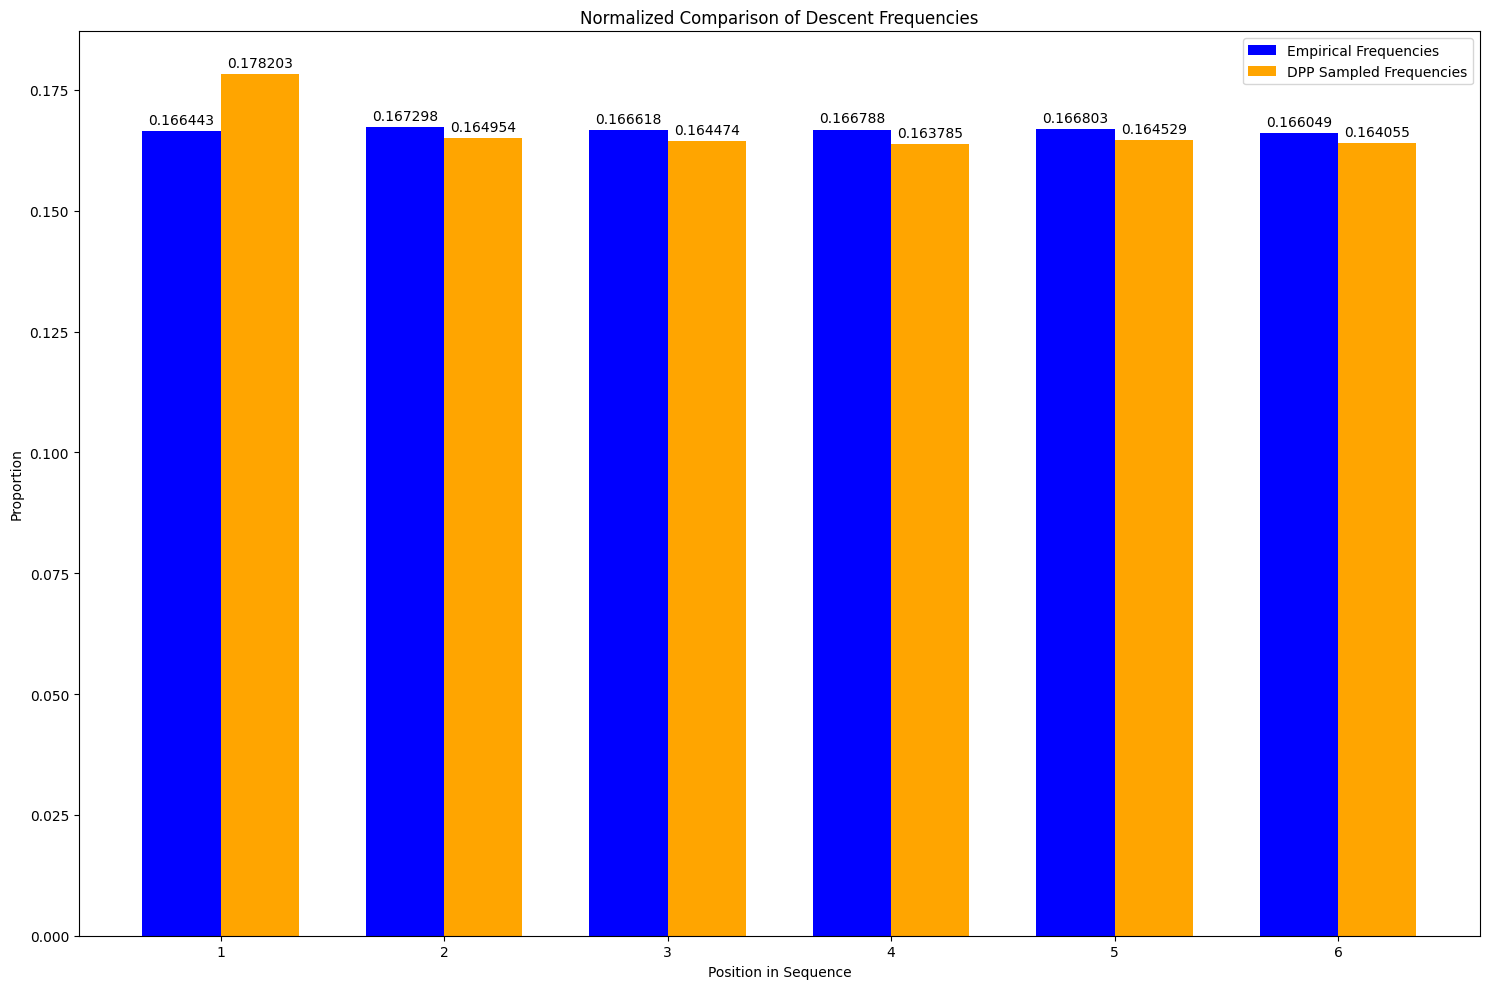

In [10]:
distr_of_indices(find_descents_in_sequence, kernel_matrix)
# distr_of_indices(find_descents_in_sequence_filtered, kernel_matrix, 3)

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_nth_largest_index(empirical_function, kernel_matrix, n):
    n_samples = 100000
    # Generate sequences
    sequences = [np.random.randint(1, 4, size=7) for _ in range(n_samples)]  
    # Calculate empirical descent frequencies
    nth_largest_empirical = []
    nth_largest_sample = []
    
    for seq in sequences:
        descents, is_valid = empirical_function(seq)
        if len(descents) >= n:
            nth_largest_empirical.append(sorted(descents, reverse=True)[n-1])  

    for i in range(0,n_samples):
        sample, _ = poulson_dpp_sampling(kernel_matrix)
        if len(sample) >= n:
            nth_largest_sample.append(sorted(sample, reverse=True)[n-1])

    # Count the frequency of each nth largest index
    empirical_freq = Counter(nth_largest_empirical)
    sample_freq = Counter(nth_largest_sample)

    # Normalize the frequencies
    empirical_normalized = {k: v / len(nth_largest_empirical) for k, v in empirical_freq.items()}
    sample_normalized = {k: v / len(nth_largest_sample) for k, v in sample_freq.items()}

    # Prepare the data for plotting
    indices = range(1, max(max(nth_largest_empirical), max(nth_largest_sample)) + 1)
    empirical_data = [empirical_normalized.get(i, 0) for i in indices]
    sample_data = [sample_normalized.get(i, 0) for i in indices]
    
    # Plotting
    pos = np.arange(len(indices))
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(15, 10))
    bars1 = ax.bar(pos - bar_width/2, empirical_data, bar_width, label='Empirical Frequencies', color='blue')
    bars2 = ax.bar(pos + bar_width/2, sample_data, bar_width, label='DPP Sampled Frequencies', color='orange')

    # Add values on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Labels and title
    ax.set_xticks(pos)
    ax.set_xticklabels([str(i) for i in indices])
    ax.set_xlabel('Nth Largest Index')
    ax.set_ylabel('Proportion')
    ax.set_title('Normalized Frequencies of Nth Largest Indices')
    plt.legend()

    plt.tight_layout()
    plt.show()

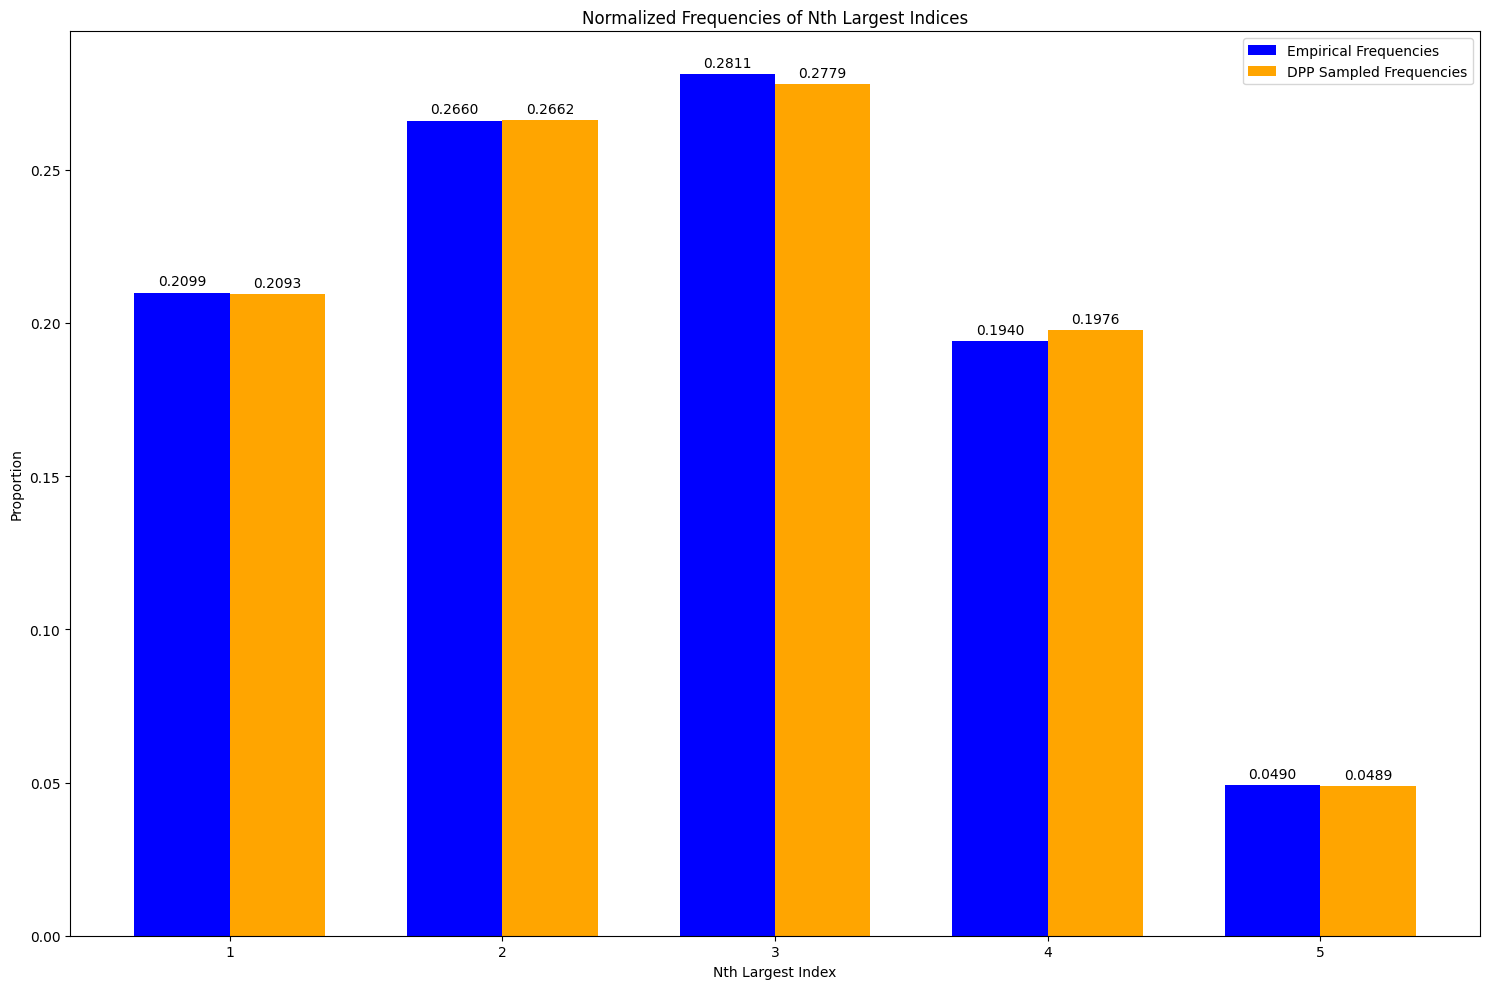

In [83]:
plot_nth_largest_index(find_descents_in_sequence, kernel_matrix, n=2)

In [276]:
def distr_of_indices_L(empirical_function, kernel_matrix, s):
    # Generate sequences
    sequences = [np.random.randint(1, 4, size=7) for _ in range(1000)]
    print(sequences)
    all_descents = []
    for seq in sequences:
        descents, is_valid = empirical_function(seq, s)
        if is_valid:
            all_descents.extend(descents)

    all_descents = [d for d in all_descents if d > s]  # Filter descents to only those greater than s

    # Handling the empirical descents
    max_descent = 0
    descent_frequencies = []
    if all_descents:
        max_descent = max(all_descents)
        descent_counts = np.bincount(all_descents, minlength=max_descent+1)
        descent_frequencies = descent_counts / np.sum(descent_counts)
    else:
        descent_frequencies = np.zeros(s+1)

    # Adjust for DPP sampling
    sample_counts = np.zeros(max_descent + 1)  # Ensure this covers the range of shifted samples
    num_samples = 1000
    for _ in range(num_samples):
        sample, _ = poulson_dpp_sampling(kernel_matrix)
        shifted_samples = [idx + s for idx in sample]  # Shift by s
        for idx in shifted_samples:
            if idx < len(sample_counts):
                sample_counts[idx] += 1

    sample_frequencies = sample_counts / np.sum(sample_counts)

    # Plotting
    max_index = max(max_descent, max(shifted_samples))
    positions = np.arange(s + 1, max_index + 1)  # Adjust to start from s+1
    bar_width = 0.35

    plt.figure(figsize=(10, 6))
    empirical_bars = None
    sample_bars = None
    if len(descent_frequencies) > s:
        empirical_bars = plt.bar(positions - bar_width/2, descent_frequencies[s+1:max_index+1], bar_width, label='Empirical Frequencies', color='blue')
    if len(sample_frequencies) > s:
        sample_bars = plt.bar(positions + bar_width/2, sample_frequencies[s+1:max_index+1], bar_width, label='DPP Sampled Frequencies (1000 samples)', color='orange')

    plt.xlabel('Index')
    plt.ylabel('Frequency')
    plt.title('Comparison of Frequencies for Indices > s (Shifted for DPP)')
    plt.xticks(positions)
    plt.legend()

    # Adding numbers on top of each bar
    if empirical_bars:
        for bar in empirical_bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

    if sample_bars:
        for bar in sample_bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [277]:
def compute_K_prime(K, s):
    # Calculate L = K(I - K)^-1
    I = np.eye(K.shape[0])  # Identity matrix of the same dimension as K
    try:
        L = K @ np.linalg.inv(I - K)
    except np.linalg.LinAlgError:
        raise ValueError("Matrix (I - K) is singular and cannot be inverted.")
    
    # Extract the submatrix of L up to the index s (assuming 0-based indexing, exclusive of s)
    L_ss = L[:s, :s]
    
    # Compute K' = L[s,s] / (I + L[s,s])
    I_ss = np.eye(s)  # Identity matrix of the dimension specified by s
    K_prime = L_ss / (I_ss + L_ss)
    
    return K_prime

[array([2, 3, 2, 3, 3, 3, 1]), array([2, 1, 2, 3, 1, 1, 2]), array([2, 2, 3, 3, 1, 2, 3]), array([2, 3, 1, 1, 3, 1, 3]), array([1, 2, 1, 2, 1, 2, 2]), array([3, 2, 1, 3, 2, 3, 1]), array([1, 2, 3, 2, 2, 1, 3]), array([1, 3, 2, 3, 2, 1, 1]), array([2, 1, 3, 2, 1, 1, 2]), array([1, 3, 3, 2, 2, 3, 2]), array([1, 1, 2, 3, 3, 3, 1]), array([3, 2, 3, 1, 2, 1, 2]), array([2, 1, 3, 1, 1, 2, 1]), array([3, 2, 1, 3, 3, 2, 1]), array([1, 2, 2, 3, 1, 3, 2]), array([3, 3, 3, 2, 1, 3, 3]), array([2, 1, 3, 3, 3, 1, 1]), array([2, 1, 1, 3, 3, 1, 1]), array([2, 1, 2, 1, 1, 1, 1]), array([2, 3, 2, 2, 2, 2, 3]), array([1, 3, 3, 3, 2, 3, 2]), array([2, 1, 2, 2, 1, 3, 2]), array([3, 3, 1, 2, 3, 1, 1]), array([1, 1, 3, 3, 3, 2, 2]), array([3, 3, 3, 2, 3, 1, 1]), array([1, 2, 2, 2, 2, 3, 3]), array([1, 1, 3, 3, 2, 1, 1]), array([2, 2, 2, 2, 1, 1, 2]), array([3, 3, 2, 3, 1, 2, 3]), array([3, 2, 1, 2, 3, 2, 1]), array([1, 1, 1, 2, 1, 2, 3]), array([3, 2, 1, 1, 1, 1, 1]), array([2, 1, 3, 1, 1, 3, 1]), array([2,

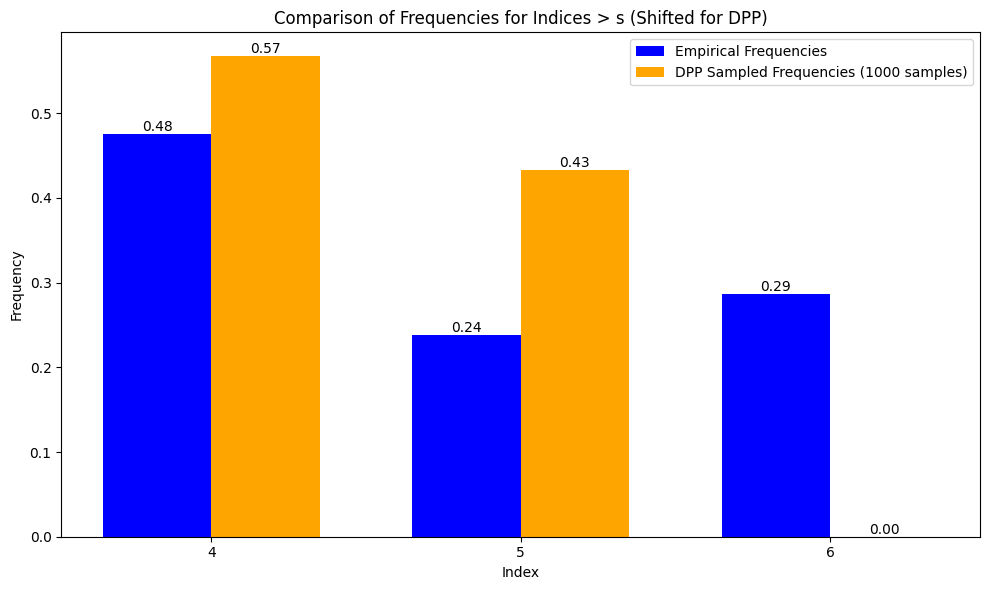

array([[0.57142857, 1.        , 1.        ],
       [1.        , 0.71428571, 1.        ],
       [1.        , 1.        , 0.76      ]])

In [278]:
s = 3
K_prime = compute_K_prime(kernel_matrix,s)
distr_of_indices_L(find_descents_and_check_validity, K_prime, s)
K_prime

In [246]:
def distr_of_indices_largest(empirical_function, kernel_matrix, s, samples=100):
    sequences = [np.random.randint(1, 4, size=7) for _ in range(samples)]
    kernel_matrix = kernel_matrix[:s, :s]  # Adjust kernel_matrix size based on s
    print(kernel_matrix)
    largest_sampled_indices = np.zeros(samples)
    largest_empirical_indices = np.zeros(samples)

    # Calculate the largest descent indices for each sequence
    for i, seq in enumerate(sequences):
        descents,_ = empirical_function(seq, s)
        # print("---")
        # print(descents)
        if descents:
            filtered_descents = [d for d in descents
                                  if d <= s]  # Filter descents based on s
            if filtered_descents:
                largest_empirical_indices[i] = max(filtered_descents)   # Adjust if descents are 0-based

    # DPP sampling to find the largest indices
    for i in range(samples):
        sample, _ = poulson_dpp_sampling(kernel_matrix)
        # print(sample)
        if len(sample) > 0:
            filtered_sample = [idx for idx in sample if idx <= s]  # Filter sampled indices based on s
            if filtered_sample:
                largest_sampled_indices[i] = max(filtered_sample)

    # Normalize histograms for the range 2 to s
    bins = np.arange(1, s)
    print(largest_sampled_indices)
    print(largest_empirical_indices)
    sample_hist, _ = np.histogram(largest_sampled_indices, bins=bins, density=True)
    empirical_hist, _ = np.histogram(largest_empirical_indices, bins=bins, density=True)
    print(sample_hist)
    print(empirical_hist)
    # Plot
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    indices = np.arange(1, s+1)

    bars1 = plt.bar(indices - bar_width / 2, sample_hist, bar_width, label='DPP Sampled Largest Index', color='orange')
    bars2 = plt.bar(indices + bar_width / 2, empirical_hist, bar_width, label='Empirical Largest Index of Descents', color='blue')

    plt.xlabel('Index')
    plt.ylabel('Normalized Frequency')
    plt.title(f'Comparison of Histograms for Largest Indices (2 to {s})')
    plt.xticks(indices)
    plt.legend()

    # Adding data labels on top of each bar
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

[[ 0.33333333  0.22222222  0.11111111  0.03703704  0.         -0.01234568]
 [ 0.33333333  0.33333333  0.22222222  0.11111111  0.03703704  0.        ]
 [ 0.          0.33333333  0.33333333  0.22222222  0.11111111  0.03703704]
 [ 0.          0.          0.33333333  0.33333333  0.22222222  0.11111111]
 [ 0.          0.          0.          0.33333333  0.33333333  0.22222222]
 [ 0.          0.          0.          0.          0.33333333  0.33333333]]
[1. 4. 1. 1. 4. 6. 5. 6. 6. 4. 5. 6. 3. 4. 5. 4. 0. 5. 4. 4. 5. 4. 6. 4.
 4. 5. 5. 6. 5. 3. 2. 5. 6. 4. 6. 6. 5. 3. 5. 1. 5. 4. 6. 0. 3. 4. 6. 3.
 6. 4. 5. 4. 4. 6. 6. 2. 5. 6. 6. 6. 3. 1. 5. 6. 4. 6. 5. 6. 6. 6. 6. 2.
 6. 2. 5. 2. 5. 1. 6. 6. 6. 5. 6. 6. 6. 6. 6. 5. 6. 5. 4. 4. 1. 5. 2. 1.
 5. 6. 6. 6.]
[4. 4. 5. 5. 6. 2. 5. 6. 6. 6. 6. 5. 3. 5. 4. 4. 2. 6. 6. 4. 6. 3. 6. 3.
 4. 2. 4. 6. 5. 6. 6. 4. 6. 6. 3. 5. 4. 5. 2. 6. 6. 6. 5. 3. 6. 6. 4. 5.
 5. 3. 5. 3. 6. 5. 5. 3. 5. 6. 6. 4. 6. 6. 4. 6. 4. 5. 6. 3. 5. 1. 5. 4.
 3. 5. 6. 5. 5. 4. 5. 6.

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (7,) and arg 1 with shape (5,).

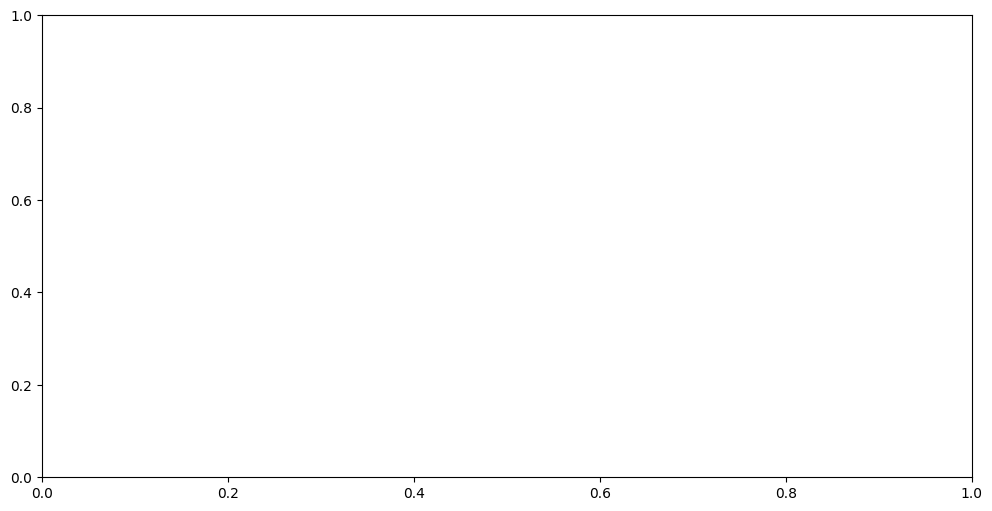

In [247]:
# distr_of_indices(find_descents_in_sequence, kernel_matrix, 6)
distr_of_indices_largest(find_descents_in_sequence_filtered, kernel_matrix, 7)

In [101]:
kernel_matrix

array([[ 0.33333333,  0.22222222,  0.11111111,  0.03703704,  0.        ,
        -0.01234568],
       [ 0.33333333,  0.33333333,  0.22222222,  0.11111111,  0.03703704,
         0.        ],
       [ 0.        ,  0.33333333,  0.33333333,  0.22222222,  0.11111111,
         0.03703704],
       [ 0.        ,  0.        ,  0.33333333,  0.33333333,  0.22222222,
         0.11111111],
       [ 0.        ,  0.        ,  0.        ,  0.33333333,  0.33333333,
         0.22222222],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.33333333,
         0.33333333]])

In [248]:
def plot_nth_largest(empirical_function, kernel_matrix, n, s, samples=1000000, sequence_length=6):
    sequences = [np.random.randint(0, 3, size=sequence_length) for _ in range(samples)]
    kernel_matrix = kernel_matrix[:s, :s]  # Adjust kernel_matrix size based on s

    nth_largest_sampled_indices = []
    nth_largest_empirical_indices = []

    # Process sequences to find empirical nth largest descents
    for seq in sequences:
        descents = empirical_function(seq, s)
        if len(descents) >= n:
            nth_largest_empirical_indices.append(sorted(descents, reverse=True)[n-1] + 1)  # Adjust for 1-based indexing

    # Process DPP sampling to find nth largest indices
    for _ in range(samples):
        sample, _ = poulson_dpp_sampling(kernel_matrix)
        if len(sample) >= n:
            nth_largest_sampled_indices.append(sorted(sample, reverse=True)[n-1])  # Assuming 1-based indexing

    # Adjust bins to limit plotting to indices <= s
    bins = np.arange(1.5, s + 1.5)
    sample_hist, _ = np.histogram(nth_largest_sampled_indices, bins=bins, density=True)
    empirical_hist, _ = np.histogram(nth_largest_empirical_indices, bins=bins, density=True)

    # Plotting adjustments for <= s
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    indices = np.arange(2, s + 1)  # Adjust plotting indices to cover 2 through s

    bars1 = plt.bar(indices - bar_width/2, sample_hist, bar_width, label=f'DPP Sampled {n}th Largest Index', color='orange')
    bars2 = plt.bar(indices + bar_width/2, empirical_hist, bar_width, label=f'Empirical {n}th Largest Index', color='blue')

    plt.xlabel('Index')
    plt.ylabel('Normalized Frequency')
    plt.title(f'Comparison of Histograms for {n}th Largest Indices (up to index {s})')
    plt.xticks(indices)
    plt.legend()

    # Adding data labels for bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

/Users/advaykoranne/Library/Python/3.9/lib/python/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


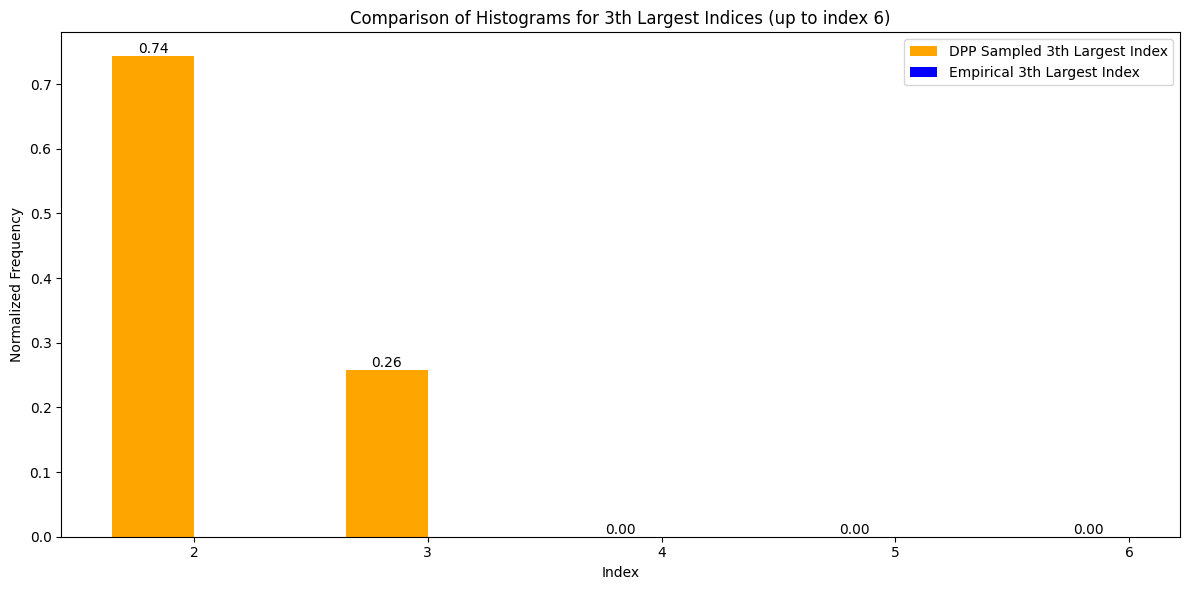

In [250]:
plot_nth_largest(find_descents_in_sequence_filtered, kernel_matrix, n=3, s=6, samples=1000, sequence_length=6)

In [ ]:
import numpy as np
from scipy.special import factorial

# Define the weight function
def w_a_M(x, a, M):
    return np.exp(-a) * (a/M)**x / factorial(x)

# Define the normalized Charlier polynomials
def c_M(x, a_over_M, M, n):
    # The recursive formula or any other method to compute Charlier polynomials
    # will go here. As a placeholder, we'll use a simple polynomial for demonstration:
    return (-1)**n * factorial(n) / factorial(x) * (a_over_M)**x * np.polynomial.hermite.hermval(a_over_M * x, [0]*n + [1])

# Define the Charlier kernel
def charlier_kernel(x, y, a, M):
    a_over_M = a / M
    if x != y:
        result = (c_M(x, a_over_M, M, M) * c_M(y, a_over_M, M, M - 1) -
                  c_M(x, a_over_M, M, M - 1) * c_M(y, a_over_M, M, M)) / (x - y)
    else:
        result = (c_M(x, a_over_M, M, M) * c_M(x, a_over_M, M, M - 1) -
                  c_M(x, a_over_M, M, M - 1) * c_M(x, a_over_M, M, M))

    return result * np.sqrt(w_a_M(x, a, M) * w_a_M(y, a, M))

# Example usage:
a = 0.8  # Replace with the relevant value of alpha
M = 5   # Replace with the relevant value of M

# Calculate the kernel for some values x and y
x = 3
y = 5
# print(charlier_kernel(x, y, a, M))

# If you want to calculate the kernel matrix for a range of x and y, use:
charlie_kernel_matrix = np.array([[charlier_kernel(i, j, a, M) for j in range(M)] for i in range(M)])
print(charlie_kernel_matrix)

[[     0.    -18433.81    -374.028     -3.76      -0.021]
 [-18433.81       0.       -26.881     -0.3       -0.002]
 [  -374.028    -26.881      0.        -0.008     -0.   ]
 [    -3.76      -0.3       -0.008      0.        -0.   ]
 [    -0.021     -0.002     -0.        -0.         0.   ]]


In [ ]:
from scipy.linalg import eigh

def is_positive_semi_definite(matrix):
    # Check if all eigenvalues are non-negative
    eigenvalues, _ = eigh(matrix)
    return np.all(eigenvalues >= 0), eigenvalues


In [ ]:
is_positive_semi_definite(charlie_kernel_matrix)

(False, array([-18438.169,      0.   ,      0.   ,      1.09 ,  18437.079]))

In [ ]:
# Set print options for nice formatting
np.set_printoptions(precision=3, suppress=True)

# Print the array
print(charlie_kernel_matrix)

[[     0.    -18433.81    -374.028     -3.76      -0.021]
 [-18433.81       0.       -26.881     -0.3       -0.002]
 [  -374.028    -26.881      0.        -0.008     -0.   ]
 [    -3.76      -0.3       -0.008      0.        -0.   ]
 [    -0.021     -0.002     -0.        -0.         0.   ]]


In [ ]:
samples = []
for _ in range(1000):  # Adjust the number of iterations as needed
    sample, _ = poulson_dpp_sampling(kernel_matrix)
    samples.append(sample)

# Check the number of non-empty samples
non_empty_samples = [s for s in samples if s]
print(f"Number of non-empty samples: {len(non_empty_samples)}")

Number of non-empty samples: 0


In [21]:
def length_of_longest_weakly_increasing_subsequence(word):
    """
    This function takes a list of integers `word` and returns the length of the longest weakly increasing subsequence.
    """
    # The length of the longest subsequence at each position
    lengths = [1] * len(word)

    # Populate lengths using dynamic programming
    for i in range(len(word)):
        for j in range(i):
            if word[i] >= word[j] and lengths[j] + 1 > lengths[i]:
                lengths[i] = lengths[j] + 1

    # Return the length of the longest weakly increasing subsequence
    return max(lengths)

# Example usage:
example_word = [3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5]
length_longest_subsequence = length_of_longest_weakly_increasing_subsequence(example_word)
print(length_longest_subsequence)

5


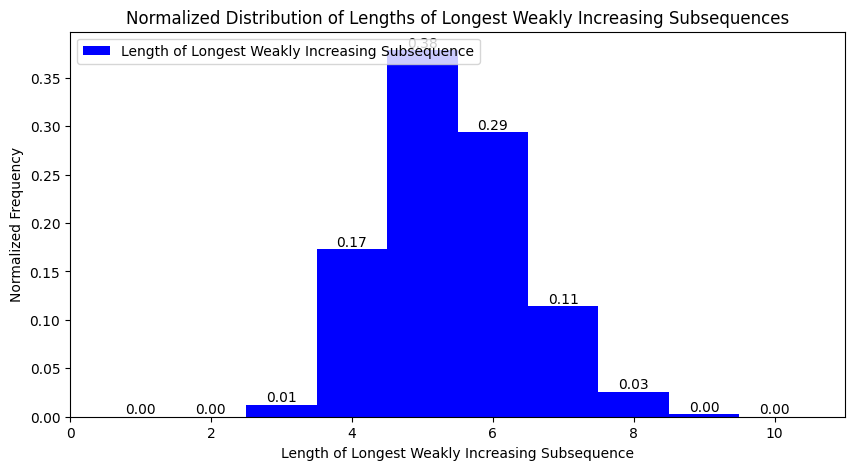

In [26]:
# Generate random words
M, N, num_words = 5, 10, 10000  # Parameters: M (max number), N (length of word), num_words (number of words)
words = np.random.randint(1, M+1, (num_words, N))

# Get the distribution of lengths of the longest weakly increasing subsequences
length_distribution = [length_of_longest_weakly_increasing_subsequence(word) for word in words]

plt.figure(figsize=(10, 5))
n, bins, patches = plt.hist(length_distribution, bins=range(1, N+2), align='left', color='blue', density=True)

# Normalize the histogram
for patch in patches:
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2., height, f'{height:.2f}', ha='center', va='bottom')

# Add a legend, titles, and labels as before
plt.legend(['Length of Longest Weakly Increasing Subsequence'], loc='upper left')
plt.title('Normalized Distribution of Lengths of Longest Weakly Increasing Subsequences')
plt.xlabel('Length of Longest Weakly Increasing Subsequence')
plt.ylabel('Normalized Frequency')

plt.show()

In [67]:
## Max Probabilities Function

sequences = [np.random.randint(1, 4, size=7) for _ in range(1000)]
print(sequences)
all_descents = []
for seq in sequences:
    descents, is_valid = find_descents_in_sequence(seq, s)
    if is_valid:
        all_descents.extend(descents)


[array([1, 2, 2, 1, 1, 3, 2]), array([3, 3, 3, 1, 3, 1, 2]), array([2, 1, 2, 2, 3, 3, 3]), array([3, 2, 1, 1, 3, 2, 2]), array([1, 2, 1, 1, 1, 1, 1]), array([2, 2, 3, 1, 3, 2, 2]), array([2, 3, 1, 1, 2, 1, 3]), array([2, 1, 1, 3, 3, 2, 1]), array([2, 3, 2, 1, 3, 2, 1]), array([2, 3, 3, 2, 3, 2, 2]), array([2, 2, 1, 1, 2, 3, 3]), array([2, 3, 1, 1, 1, 2, 1]), array([2, 1, 3, 3, 1, 2, 3]), array([3, 2, 3, 2, 2, 3, 1]), array([2, 1, 1, 1, 1, 2, 2]), array([2, 1, 1, 3, 3, 1, 2]), array([1, 1, 1, 1, 2, 1, 3]), array([3, 3, 3, 2, 1, 1, 3]), array([1, 3, 2, 1, 1, 1, 3]), array([3, 1, 1, 1, 1, 3, 3]), array([3, 3, 2, 1, 3, 2, 3]), array([2, 2, 3, 3, 2, 3, 1]), array([2, 2, 3, 3, 3, 3, 3]), array([3, 2, 1, 1, 1, 1, 2]), array([2, 1, 3, 2, 1, 3, 1]), array([3, 1, 3, 3, 1, 1, 1]), array([1, 2, 1, 1, 2, 1, 1]), array([3, 1, 1, 1, 1, 2, 2]), array([1, 3, 1, 2, 3, 1, 1]), array([2, 1, 3, 2, 2, 3, 3]), array([2, 1, 2, 1, 2, 2, 1]), array([1, 1, 3, 1, 3, 1, 2]), array([2, 2, 1, 3, 3, 2, 2]), array([3,

TypeError: find_descents_in_sequence() takes 1 positional argument but 2 were given

In [80]:
import sympy as sp
import numpy as np

def compute_coefficients(b):
    t = sp.symbols('t')
    # Adjust the series expansion order if necessary
    expansion = sp.series(1 / (1 - (1 - t)**b), t, 0, 21).removeO()
    coeffs = [expansion.coeff(t, n) for n in range(-10, 11)]
    return coeffs

b = 3
coefficients = compute_coefficients(b)
coeff_dict = {m: coeff for m, coeff in enumerate(coefficients, start=-10)}
size = 6

# Set precision to desired number of decimal places
precision = 50

kernel_matrix = np.zeros((size, size), dtype=float)  # Use float for decimal precision

for i in range(size):
    for j in range(size):
        m = j - i
        coeff = coeff_dict.get(m, 0)
        # Convert the sympy Rational to a Decimal with the specified precision
        kernel_matrix[i, j] = float(sp.N(coeff, n=precision))

print(kernel_matrix)

[[ 0.33333333  0.22222222  0.11111111  0.03703704  0.         -0.01234568]
 [ 0.33333333  0.33333333  0.22222222  0.11111111  0.03703704  0.        ]
 [ 0.          0.33333333  0.33333333  0.22222222  0.11111111  0.03703704]
 [ 0.          0.          0.33333333  0.33333333  0.22222222  0.11111111]
 [ 0.          0.          0.          0.33333333  0.33333333  0.22222222]
 [ 0.          0.          0.          0.          0.33333333  0.33333333]]


In [81]:
import numpy as np

def find_descents_in_sequence(seq, s=None):
    descents = [i+1 for i in range(len(seq) - 1) if seq[i] > seq[i + 1]]
    is_valid = len(descents) > 0
    return descents, is_valid

sequences = [np.random.randint(1, 4, size=7) for _ in range(1000000)]

all_descents = []
max_descent_indices = []  # To store maximum descent index for each valid sequence
for seq in sequences:
    descents, is_valid = find_descents_in_sequence(seq)
    if is_valid:
        all_descents.extend(descents)
        # Safely finding the max, as we now know descents is not empty
        max_descent_indices.append(max(descents))

# Calculating cumulative probabilities
cumulative_probabilities = {f"<{i}": sum(np.array(max_descent_indices) < i) / len(max_descent_indices) for i in range(6, 1, -1)}
# Adding P(<7) as 1 since the maximum index in a sequence of length 7 cannot exceed 6
cumulative_probabilities["<7"] = 1.0

# Handling the case when there are no valid sequences with a descent index of 1
if "<1" not in cumulative_probabilities:
    cumulative_probabilities["<1"] = 0.0

# Calculating exact probabilities for P(max index = 6), P(max index = 5), etc.
exact_probabilities = {}
for i in range(6, 1, -1):
    exact_probabilities[f"={i}"] = cumulative_probabilities[f"<{i}"] - cumulative_probabilities.get(f"<{i-1}", 0.0)

print(cumulative_probabilities)
print(exact_probabilities)

{'<6': 0.6620100371716975, '<5': 0.36028891437495425, '<4': 0.17194553573607282, '<3': 0.07142842618123846, '<2': 0.022340637531213653, '<7': 1.0, '<1': 0.0}
{'=6': 0.30172112279674324, '=5': 0.18834337863888143, '=4': 0.10051710955483437, '=3': 0.049087788650024805, '=2': 0.022340637531213653}


In [82]:
import numpy as np

# Initialize an empty dictionary to store the probabilities.
probabilities = {}
K = kernel_matrix

# Loop to calculate P(X<n) for n from 6 down to 1
for i in range(6, 0, -1):
    # Select the bottom right i x i submatrix of K.
    K_submatrix = K[i-1:, i-1:]
    print("----")
    print(i)
    print(K_submatrix)
    # Create an i x i identity matrix.
    I_submatrix = np.eye(len(K_submatrix))
    # Compute the matrix to take determinant of, I - K_submatrix.
    matrix_to_determine = I_submatrix - K_submatrix
    # Calculate the determinant.
    det = np.linalg.det(matrix_to_determine)
    # Store the probability in the dictionary.
    probabilities[f'<{i}'] = det


# Calculate the cumulative probabilities
cumulative_probabilities = probabilities.copy()
cumulative_probabilities['<7'] = 1.0

# Print out the cumulative probabilities
print("\nCumulative Probabilities:")
print(cumulative_probabilities)
# Calculating exact probabilities for P(max index = 6), P(max index = 5), etc.
exact_probabilities = {}
for i in range(6, 1, -1):
    exact_probabilities[f"={i}"] = cumulative_probabilities[f"<{i}"] - cumulative_probabilities[f"<{i-1}"]
# Print out the exact probabilities
print("Exact Probabilities:")
print(exact_probabilities)


----
6
[[0.33333333]]
----
5
[[0.33333333 0.22222222]
 [0.33333333 0.33333333]]
----
4
[[0.33333333 0.22222222 0.11111111]
 [0.33333333 0.33333333 0.22222222]
 [0.         0.33333333 0.33333333]]
----
3
[[0.33333333 0.22222222 0.11111111 0.03703704]
 [0.33333333 0.33333333 0.22222222 0.11111111]
 [0.         0.33333333 0.33333333 0.22222222]
 [0.         0.         0.33333333 0.33333333]]
----
2
[[0.33333333 0.22222222 0.11111111 0.03703704 0.        ]
 [0.33333333 0.33333333 0.22222222 0.11111111 0.03703704]
 [0.         0.33333333 0.33333333 0.22222222 0.11111111]
 [0.         0.         0.33333333 0.33333333 0.22222222]
 [0.         0.         0.         0.33333333 0.33333333]]
----
1
[[ 0.33333333  0.22222222  0.11111111  0.03703704  0.         -0.01234568]
 [ 0.33333333  0.33333333  0.22222222  0.11111111  0.03703704  0.        ]
 [ 0.          0.33333333  0.33333333  0.22222222  0.11111111  0.03703704]
 [ 0.          0.          0.33333333  0.33333333  0.22222222  0.11111111]
 [ 

{'=6': 0.30172112279674324, '=5': 0.18834337863888143, '=4': 0.10051710955483437, '=3': 0.049087788650024805, '=2': 0.022340637531213653}
